In [24]:
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from dask import delayed
from tqdm import tqdm
import dask
import matplotlib.pyplot as plt
from shapely.geometry import box
from tqdm import tqdm
from shapely.geometry import Polygon
import libpysal
import pandas as pd
from libpysal.weights import W
import momepy
import pickle
import contextily as ctx
from shapely.wkb import loads

In [25]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [26]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='70GB')

client = Client(daskCluster)

client

c:\ProgramData\anaconda3\envs\processor\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64436 instead
  warnings.warn(


c:\ProgramData\anaconda3\envs\processor\Lib\contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.36s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
2023-12-15 19:22:33,759 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 19:22:33,787 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 19:22:33,805 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 19:22:33,822 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-15 19:22:33,840 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory l

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:64436/status,
Dashboard: http://127.0.0.1:64436/status,Workers: 8
Total threads: 16,Total memory: 511.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64441,Workers: 8
Dashboard: http://127.0.0.1:64436/status,Total threads: 16
Started: Just now,Total memory: 511.38 GiB
Comm: tcp://127.0.0.1:64481,Total threads: 2
Dashboard: http://127.0.0.1:64486/status,Memory: 63.92 GiB
Nanny: tcp://127.0.0.1:64444,


In [27]:
tessellation = pd.read_parquet(f"../output/{place}/tessellation_p2.pq",engine='fastparquet')
tessellation['geometry'] = tessellation['geometry'].apply(lambda x: loads(x) if x else None)
tessellation = gpd.GeoDataFrame(tessellation, geometry="geometry").set_crs(local_crs)


KeyboardInterrupt: 

In [ ]:
buildings = gpd.read_parquet(f"../output/{place}/buildings_p2.pq").to_crs(local_crs)
rail = gpd.read_parquet(f"../output/{place}/rail_raw.pq").to_crs(local_crs).reset_index(drop=True)
streets = gpd.read_parquet(f"../output/{place}/streets_p2.pq").to_crs(local_crs).explode()

C:\Users\reube\AppData\Local\Temp\ipykernel_23124\3940769369.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").to_crs(local_crs).explode()


In [ ]:
study_area = gpd.read_parquet(f"../output/{place}/study_area.pq").to_crs(local_crs)

In [ ]:
buildings[~buildings.geom_type.eq('Polygon')]

,uID,geometry
15893,15893,"MULTIPOLYGON (((257135.975 664895.210, 257135...."
188545,188545,"MULTIPOLYGON (((264978.838 660151.505, 264975...."
210930,210930,"MULTIPOLYGON (((264449.744 660495.303, 264449...."
220351,220351,"MULTIPOLYGON (((263828.484 665043.678, 263828...."


In [ ]:
buildings[buildings["uID"] == 48]

,uID,geometry
48,48,"POLYGON ((250736.643 659684.631, 250733.981 65..."


In [ ]:
buildings.geom_type.eq('Polygon').all()
buildings[~buildings.geom_type.eq('Polygon')]

,uID,geometry
15893,15893,"MULTIPOLYGON (((257135.975 664895.210, 257135...."
188545,188545,"MULTIPOLYGON (((264978.838 660151.505, 264975...."
210930,210930,"MULTIPOLYGON (((264449.744 660495.303, 264449...."
220351,220351,"MULTIPOLYGON (((263828.484 665043.678, 263828...."


In [ ]:
tessellation.is_valid.eq('Polygon').all()
tessellation[~tessellation.geom_type.eq('Polygon')]

,uID,geometry
31,31,"MULTIPOLYGON (((243704.420 671027.049, 243703...."
58,58,"MULTIPOLYGON (((253215.104 658954.639, 253210...."
93,93,"MULTIPOLYGON (((253364.768 667978.871, 253364...."
346,346,"MULTIPOLYGON (((247642.855 671494.768, 247643...."
475,475,"MULTIPOLYGON (((256797.327 668198.877, 256797...."
...,...,...
255225,255225,"MULTIPOLYGON (((271760.569 653793.019, 271760...."
255444,255444,"MULTIPOLYGON (((263991.280 655684.559, 263991...."
256387,256387,"MULTIPOLYGON (((273539.514 654871.351, 273538...."
256601,256601,"MULTIPOLYGON (((271302.963 652619.244, 271304...."


In [ ]:
# Load your GeoDataFrame
gdf = tessellation

# Calculate the extent of the dataset
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

# Modify the create_grid function to include tqdm
def create_grid(bounds, width, height):
    minx, miny, maxx, maxy = bounds
    grid = []
    x_range = range(int((maxx - minx) / width)+1)
    y_range = range(int((maxy - miny) / height)+1)

    for x in tqdm(x_range, desc="Creating Grid"):
        x_coord = minx + x * width
        for y in y_range:
            y_coord = miny + y * height
            grid.append(box(x_coord, y_coord, x_coord + width, y_coord + height))

    return grid

grid_squares = create_grid(bounds, 10000, 10000) 

# Convert to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_squares)

Creating Grid: 100%|██████████| 9/9 [00:00<00:00, 1975.55it/s]


In [ ]:
tessellation.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

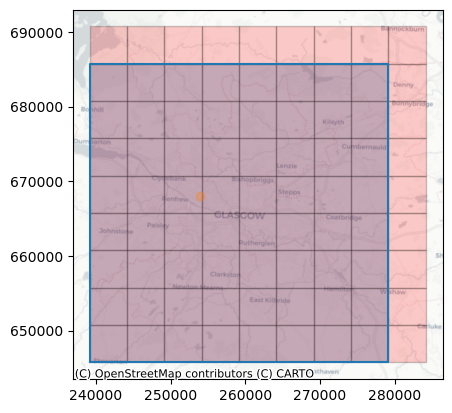

In [ ]:


# Example: Assuming gdf is your GeoDataFrame
# gdf = gpd.read_file('your_file.geojson') or any other source

# Get the total bounds
bounds = gdf.total_bounds

# Create a polygon from the bounds
# The order of points is: bottom-left, top-left, top-right, bottom-right
polygon = Polygon([(bounds[0], bounds[1]), (bounds[0], bounds[3]), 
                   (bounds[2], bounds[3]), (bounds[2], bounds[1])])

# Optional: Plotting
fig, ax = plt.subplots()
x,y = polygon.exterior.xy
plt.plot(x, y)
plt.fill(x, y, alpha=0.3)
grid_gdf.plot(ax=ax, color='red', alpha=0.2, edgecolor='black')
tessellation[tessellation["uID"] == 0].geometry.centroid.plot(ax=ax, alpha = 0.3)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=tessellation.crs)
plt.show()

In [ ]:
grid_gdf.to_parquet(f"../output/{place}/grid_gdf.pq")

In [ ]:
grid_gdf["uID"] = grid_gdf.index

In [ ]:
def find_neighbours(tessellation, cell):
    # Get 'not disjoint' countries
    neighbours = tessellation[~tessellation.geometry.disjoint(cell.geometry)].uID.tolist()
    # Remove own uID of the cell from the list
    neighbours_list = [uID for uID in neighbours if cell.uID != uID]
    return neighbours_list

out = []

for index, cell in grid_gdf.iterrows():
    # Add the delayed task to the current batch
    result = find_neighbours(grid_gdf, cell)
    out.append(result)

In [ ]:
grid_gdf["touching"] = out

In [ ]:
# Step 1: Calculate centroids
tessellation['centroid'] = tessellation.geometry.centroid

# Step 2: Convert centroids to a new GeoDataFrame
centroids = gpd.GeoDataFrame(tessellation, geometry='centroid')

# Step 3: Perform spatial join
joined_gdf = gpd.sjoin(centroids, grid_gdf, how='inner', op='intersects')

# Step 4: Group original polygons based on the join
grouped_gdf = tessellation.merge(joined_gdf[['centroid', 'index_right']], left_on='centroid', right_on='centroid')


C:\Users\reube\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\reube\AppData\Local\Temp\ipykernel_23124\2368018611.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

  joined_gdf = gpd.sjoin(centroids, grid_gdf, how='inner', op='intersects')


In [ ]:

# Assuming you have a GeoDataFrame 'grouped_gdf' and you're grouping by some column 'grouping_column'
grouped = grouped_gdf.groupby('index_right')

cells_in_region = {region:set() for region in grid_gdf.uID}


In [ ]:
# Extracting the uID lists for each group
for group_name, group in grouped:
    cells_in_region[group_name] = set(group['uID'].tolist())

In [ ]:
# Assuming 'grouped_gdf' is your GeoDataFrame and it's correctly defined
buffered_tessellation = grouped_gdf.copy()  # Create a copy to retain the original data

# Apply a buffer of 50 units to each geometry
buffered_tessellation["geometry"] = buffered_tessellation["geometry"].buffer(60)


In [ ]:
cells_in_expanded_region = cells_in_region.copy()

for index, region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cells = buffered_tessellation[buffered_tessellation['index_right'].isin(region.touching)]

    intersection_rows = expanded_cells[expanded_cells.intersects(region.geometry.boundary)]
    
    cells_in_expanded_region[index] = cells_in_region[index].union(set(intersection_rows.uID.tolist()))
    

100%|██████████| 81/81 [00:01<00:00, 46.74it/s]


In [ ]:
# Assuming 'grouped_gdf' is your GeoDataFrame and it's correctly defined
buffered_tessellation_200 = grouped_gdf.copy()  # Create a copy to retain the original data

# Apply a buffer of 50 units to each geometry
buffered_tessellation_200["geometry"] = buffered_tessellation["geometry"].buffer(250)

cells_in_expanded_region_200 = cells_in_region.copy()

for index, region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cells = buffered_tessellation_200[buffered_tessellation_200['index_right'].isin(region.touching)]

    intersection_rows = expanded_cells[expanded_cells.intersects(region.geometry.boundary)]
    
    cells_in_expanded_region_200[index] = cells_in_region[index].union(set(intersection_rows.uID.tolist()))
    

KeyboardInterrupt: 

In [ ]:
list_of_weights = []

for index, expanded_region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cell_gdf = tessellation[tessellation['uID'].isin(list(cells_in_expanded_region[index]))] 
    list_of_weights.append(libpysal.weights.fuzzy_contiguity(expanded_cell_gdf, tolerance=0.05, buffering=True, drop=True, buffer=5, ids="uID", silence_warnings=True))


In [ ]:
adjlist_combined = None
for index, weight in tqdm(enumerate(list_of_weights), total= len(list_of_weights)):
    
    adjlist = list_of_weights[index].to_adjlist()
    
    if index == 0:
        adjlist_combined = adjlist
    
    else:
        adjlist_combined = pd.concat([adjlist_combined, adjlist])

In [ ]:
import pandas as pd
import libpysal
from libpysal.weights import W

# Example DataFrame
# df = pd.DataFrame({
#     'observation': [...],
#     'neighbor': [...]
# })

def df_to_weights(df):
    neighbors_dict = {}
    for idx, row in df.iterrows():
        obs = row['observation']
        neighbor = row['neighbor']

        if obs in neighbors_dict:
            neighbors_dict[obs].add(neighbor)
        else:
            neighbors_dict[obs] = {neighbor}
        
        # Optional: add the reverse relationship
        # if neighbor in neighbors_dict:
        #     neighbors_dict[neighbor].add(obs)
        # else:
        #     neighbors_dict[neighbor] = {obs}

    # Convert sets to lists for the W object
    for obs in neighbors_dict:
        neighbors_dict[obs] = list(neighbors_dict[obs])

    w = W(neighbors_dict)
    return w

# Example usage
w = df_to_weights(adjlist_combined)


pickle_and_save_object(w, f"../output/{place}/queen_3.pkl")

In [ ]:
unique_ids = tessellation['uID'].unique().tolist()

In [ ]:
uID_neighbours = {uID: set() for uID in unique_ids}

In [ ]:
for index, row in adjlist_combined.iterrows():
    uID_neighbours[row["focal"]].add(row["neighbor"])

In [ ]:
three_queen_region = {}
for region in tqdm(cells_in_region):
    cells_to_search = cells_in_region[region]
    output = cells_in_region[region]
    for i in range(5):
        cells_found_in_current_iteration = set()
        
        for cell in cells_to_search:
            cells_found_in_current_iteration = cells_found_in_current_iteration.union(uID_neighbours[cell])
        
        cells_to_search = cells_found_in_current_iteration.difference(output)
        
        output = output.union(cells_found_in_current_iteration)
        
    three_queen_region[region] = output

In [ ]:
from math import ceil

In [ ]:
filtered_gdf2 = tessellation[tessellation['uID'].isin(cells_in_region[ceil(len(three_queen_region)/2)])]
filtered_gdf = tessellation[tessellation['uID'].isin(three_queen_region[ceil(len(three_queen_region)/2)])]

import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots()

# Plot the first GeoDataFrame


# Plot the second GeoDataFrame


filtered_gdf.plot(ax=ax, color='red', edgecolor='k', alpha=1)

filtered_gdf2.plot(ax=ax, color='green', edgecolor='k', alpha=1)


# Customize the plot (optional)
ax.set_title("Overlay of filtered_gdf and cells_in_region")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:
with open(f"../output/{place}/three_queen_region.pq", 'wb') as file:
    pickle.dump(three_queen_region, file)

In [ ]:
queen_3_combined = []

## Morphometrics

In [ ]:
## Create Weights
buildings_local_out_combined = pd.DataFrame()
tessellation_out_combined = pd.DataFrame()

for cell_index in tqdm(three_queen_region):
    print("new cell", cell_index)
    
    if buildings[buildings['uID'].isin(three_queen_region[cell_index])].empty:
        continue
    
    filtered_df = adjlist_combined[
            adjlist_combined['focal'].isin(three_queen_region[cell_index]) & 
            adjlist_combined['neighbor'].isin(three_queen_region[cell_index])
        ]
    buildings_dist200 = buildings[buildings["uID"].isin(cells_in_expanded_region_200)]
    
    queen_1 = W.from_adjlist(filtered_df)

    queen_3 = momepy.sw_high(k=3, weights=queen_1)
    
    queen_3_combined.append(queen_3)

    dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings_dist200, 200, ids='uID')
    
    buildings_local = buildings[buildings['uID'].isin(three_queen_region[cell_index])]

    buildings_dist200["buildings_neighbours_200"] = momepy.Neighbors(buildings_dist200, dist200, 'uID', weighted=True).series

    buildings_out = buildings[buildings["uID"].isin(cells_in_region[cell_index])]
    
    queen_3_adjlist = queen_3.to_adjlist()

    # Get unique values from both columns
    unique_focal = queen_3_adjlist['focal'].unique()
    unique_neighbor = queen_3_adjlist['neighbor'].unique()

    # Combine and get unique values across both columns
    all_unique_values = pd.unique(pd.concat([pd.Series(unique_focal), pd.Series(unique_neighbor)]))
    
    tessellation_out = tessellation[tessellation["uID"].isin(all_unique_values)]
    
    ### Building Area
    buildings_local['building_area'] = momepy.Area(buildings_local).series
    tessellation_out['tess_area'] = momepy.Area(tessellation_out).series
    tessellation_out['tess_compactnessweightedaxis'] = momepy.CompactnessWeightedAxis(tessellation_out).series
    
    tessellation_out["tessellation_neighbours"] = momepy.Neighbors(tessellation_out, queen_3, 'uID', weighted=True).series
    
    buildings_scattered = client.scatter(buildings_local)
    streets_scattered = client.scatter(streets)
    tessellation_scattered = client.scatter(tessellation_out)

    dist200_scattered = client.scatter(dist200)
    queen_1_scattered = client.scatter(queen_1)
    queen_3_scattered = client.scatter(queen_3)
    
    buildings_local_out = buildings_local
    
    # Function to pickle and save objects
    def pickle_and_save_object(obj, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(obj, file)
    
    # Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined
    
    jobs_names = ['building_circular_compactness', 'building_elongation', 'building_squareness', 'building_eri', 'building_orientation', "building_neighbour_dist", "building_neighbourhood_interbuilding_distance"]

    jobs = [dask.delayed(momepy.CircularCompactness)(buildings_scattered), 
            dask.delayed(momepy.Elongation)(buildings_scattered), 
            dask.delayed(momepy.Squareness)(buildings_scattered),
            dask.delayed(momepy.EquivalentRectangularIndex)(buildings_scattered), 
            dask.delayed(momepy.Orientation)(buildings_scattered), 
            dask.delayed(momepy.NeighborDistance)(buildings_scattered, queen_1_scattered, 'uID'),
            dask.delayed(momepy.MeanInterbuildingDistance)(buildings_scattered, queen_1_scattered, 'uID', 3)
            ]

    jobs_out = dask.compute(jobs)


    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        buildings_local_out[field_name] = jobs_out[0][index].series
        
    buildings_scattered = client.scatter(buildings_local_out)

    # Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ["tess_convexity", "tess_covered_area", "tess_orientation"]

    jobs = [dask.delayed(momepy.Convexity)(tessellation_scattered), 
            dask.delayed(momepy.CoveredArea)(tessellation_scattered, queen_1_scattered, "uID"),
            dask.delayed(momepy.Orientation)(tessellation_scattered)]

    jobs_out = dask.compute(jobs)

    # Assign the results back to the buildings GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        tessellation_out[field_name] = jobs_out[0][index].series

    tessellation_scattered = client.scatter(tessellation_out)
    
    # Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ['building_circular_compactness_weight', 'building_elongation_weight', 'building_squareness_weight', 'building_eri_weight', "building_neighbour_dist_weight", "building_neighbourhood_interbuilding_distance_weight", 'building_orientation_weight']

    jobs = [dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                            values='building_circular_compactness',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                            values='building_elongation',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                            values='building_squareness',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                            values='building_eri',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                            values='building_neighbour_dist',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                            values='building_neighbourhood_interbuilding_distance',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
                dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                                values='building_orientation',
                                                                spatial_weights=queen_3_scattered,
                                                                unique_id='uID')]

        jobs_out = dask.compute(*jobs)

        # Assign the results back to the buildings GeoDataFrame
        for index, field_name in enumerate(jobs_names):
            buildings_out[field_name] = jobs_out[index].series

        buildings_scattered = client.scatter(buildings_local_out)
        
        # Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

        jobs_names = ["tess_convexity_weight", "tess_covered_area_weight", "tess_orientation_weight", "building_neighbourhood_interbuilding_distance_weight", 'tess_compactnessweightedaxis_weight']

        jobs = [dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                                values="tess_convexity",
                                                                spatial_weights=queen_3_scattered,
                                                                unique_id='uID'),
                dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                                values='tess_covered_area',
                                                                spatial_weights=queen_3_scattered,
                                                                unique_id='uID'),
                dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                                values='tess_orientation',
                                                                spatial_weights=queen_3_scattered,
                                                                unique_id='uID'),
                dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                                values='building_neighbourhood_interbuilding_distance',
                                                                spatial_weights=queen_3_scattered,
                                                                unique_id='uID'),
                dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                                values='tess_compactnessweightedaxis',
                                                                spatial_weights=queen_3_scattered,
                                                                unique_id='uID')]

        jobs_out = dask.compute(*jobs)

        # Assign the results back to the buildings_local GeoDataFrame
        for index, field_name in enumerate(jobs_names):
            if index == len(jobs_names) - 1:  # Check if it's the last iteration
                buildings_local_out[field_name] = jobs_out[index].series
            else:
                tessellation_out[field_name] = jobs_out[index].series
        
        buildings_local_out = buildings_local_out.drop('geometry', axis=1)
        tessellation_out = tessellation_out.drop(['geometry', 'centroid'], axis=1)
        buildings_dist200 = buildings_dist200.drop('geometry', axis=1)
        
        if cell_index == 0:
            buildings_local_out_combined = buildings_local_out[buildings_local_out["uID"].isin(cells_in_region[cell_index])]
            tessellation_out_combined = tessellation_out[tessellation_out["uID"].isin(cells_in_region[cell_index])]
        
        else:
            buildings_local_out_combined = pd.concat([buildings_local_out_combined, buildings_local_out[buildings_local_out["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)
            tessellation_out_combined = pd.concat([tessellation_out_combined, tessellation_out[tessellation_out["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)

In [ ]:
import libpysal
from libpysal.weights import W

def merge_weights(weights_list):
    merged_weights = {}
    for w in weights_list:
        for observation, neighbors in w.neighbors.items():
            if observation not in merged_weights:
                merged_weights[observation] = set(neighbors)
            else:
                merged_weights[observation].update(neighbors)

    # Convert sets back to lists for the W object
    for observation in merged_weights:
        merged_weights[observation] = list(merged_weights[observation])

    # Creating the final merged W object
    merged_w = W(merged_weights)
    return merged_w

# Function to pickle and save objects
def pickle_and_save_object(obj, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)
        
# Pickling and saving the objects
pickle_and_save_object(merge_weights(queen_3_combined), f"../output/{place}/queen_3.pkl")

In [ ]:
continuity = momepy.COINS(streets)

stroke_attr = continuity.stroke_attribute()

stroke_gdf = continuity.stroke_gdf()

stroke_gdf.plot(stroke_gdf.length,
                figsize=(15, 15),
                cmap="viridis_r",
                linewidth=.5,
                scheme="headtailbreaks"
               ).set_axis_off()

stroke_gdf["length"] = stroke_gdf.length

stroke_gdf.to_parquet(f"../output/{place}/stroke_gdf.pq")

In [ ]:
# buildings = gpd.GeoDataFrame(buildings.merge(buildings_local_out_combined, on='uID', how='inner').merge(buildings_dist200_combined, on='uID', how='inner'), crs=local_crs)
buildings_out = gpd.GeoDataFrame(buildings.merge(buildings_local_out_combined, on='uID', how='inner'), crs=local_crs)
tessellation_out = gpd.GeoDataFrame(tessellation.merge(tessellation_out_combined, on='uID', how='inner'), crs=local_crs)

In [ ]:
buildings_out.to_parquet(f"../output/{place}/buildings_morphometric_p3.pq")
tessellation_out.to_parquet(f"../output/{place}/tessellation_morphometric_p3.pq")

In [ ]:
client.shutdown()